# Animals Image Classification

### Setup Kaggle

In [1]:
!mkdir -p ~/.kaggle
!install -m 600 kaggle.json ~/.kaggle/kaggle.json
!kaggle config view

Configuration values from /root/.kaggle
- username: nrahfi
- path: None
- proxy: None
- competition: None


### Download Dataset

In [2]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.9.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.36.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Import Required Libraries

In [3]:
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import os, sys, json, subprocess, glob

from pathlib import Path
from google.colab import drive

from matplotlib import cm
from matplotlib.colors import Normalize

from PIL import Image, UnidentifiedImageError

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization

## Data Loading

### Extract Zip File

In [4]:
BASE_PATH = '/content/'
zip_path = f"{BASE_PATH}animals10.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH)

print("Extracted To:", BASE_PATH)

Extracted To: /content/


### Translate Classes

In [5]:
translate = {
  "cane": "dog",
  "cavallo": "horse",
  "elefante": "elephant",
  "farfalla": "butterfly",
  "gallina": "chicken",
  "gatto": "cat",
  "mucca": "cow",
  "pecora": "sheep",
  "scoiattolo": "squirrel",
  "ragno": "spider"
}

### Image Sample

Class Counts:
  butterfly : 2112
  cat       : 1668
  chicken   : 3098
  cow       : 1866
  dog       : 4863
  elephant  : 1446
  horse     : 2623
  sheep     : 1820
  spider    : 4821
  squirrel  : 1862

Total Classes Found: 10


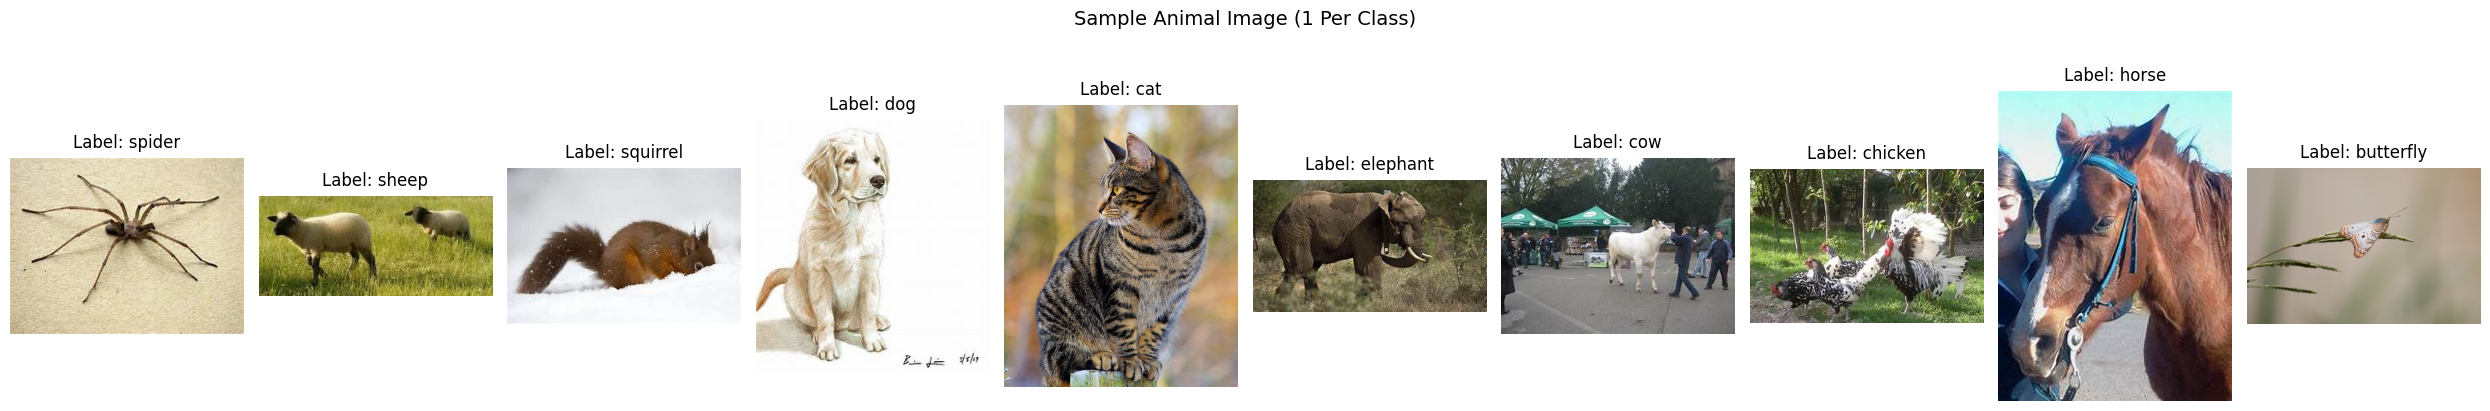

In [6]:
random.seed(42)

raw_img_path = f"{BASE_PATH}raw-img"

allowed_labels = set([
    "dog", "cat", "horse", "spider", "butterfly",
    "chicken", "sheep", "cow", "squirrel", "elephant"
])

label_to_images = {}

for img_class in os.listdir(raw_img_path):
    if img_class.startswith("."):
        continue

    class_dir = os.path.join(raw_img_path, img_class)
    if not os.path.isdir(class_dir):
        continue

    english_label = translate.get(img_class, img_class)

    if allowed_labels and english_label not in allowed_labels:
        continue

    for file in os.listdir(class_dir):
        if file.startswith("."):
            continue
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(class_dir, file)
            label_to_images.setdefault(english_label, []).append(path)

print("Class Counts:")
for lbl in sorted(label_to_images.keys()):
    print(f"  {lbl:10s}: {len(label_to_images[lbl])}")
print(f"\nTotal Classes Found: {len(label_to_images)}")

if not label_to_images:
    raise RuntimeError("No Images Found - Check Exists Folder")

selected_images = []
for label, candidates in label_to_images.items():
    if not candidates:
        continue
    for _ in range(10):
        img_path = random.choice(candidates)
        try:
            with Image.open(img_path) as img:
                img.verify()
            selected_images.append((label, img_path))
            break
        except (UnidentifiedImageError, OSError):
            continue

if not selected_images:
    raise RuntimeError("Could Not Open Images to Display - Check File Integrity")

cols = len(selected_images)
plt.figure(figsize=(2.5*cols, 4))
plt.suptitle("Sample Animal Image (1 Per Class)", fontsize=14, y=1.05)

for i, (label, img_path) in enumerate(selected_images):
    img = Image.open(img_path)
    plt.subplot(1, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}", pad=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Expl(ora/ana)tory Data Analysis

### Dataset Various Size & Resolutions

Total Image Detected: 26179
            Width      Height
count  100.000000  100.000000
mean   295.450000  236.870000
std     71.210936   56.146931
min    155.000000  142.000000
25%    300.000000  200.000000
50%    300.000000  225.000000
75%    300.000000  280.750000
max    640.000000  437.000000


/tmp/ipython-input-3193019902.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


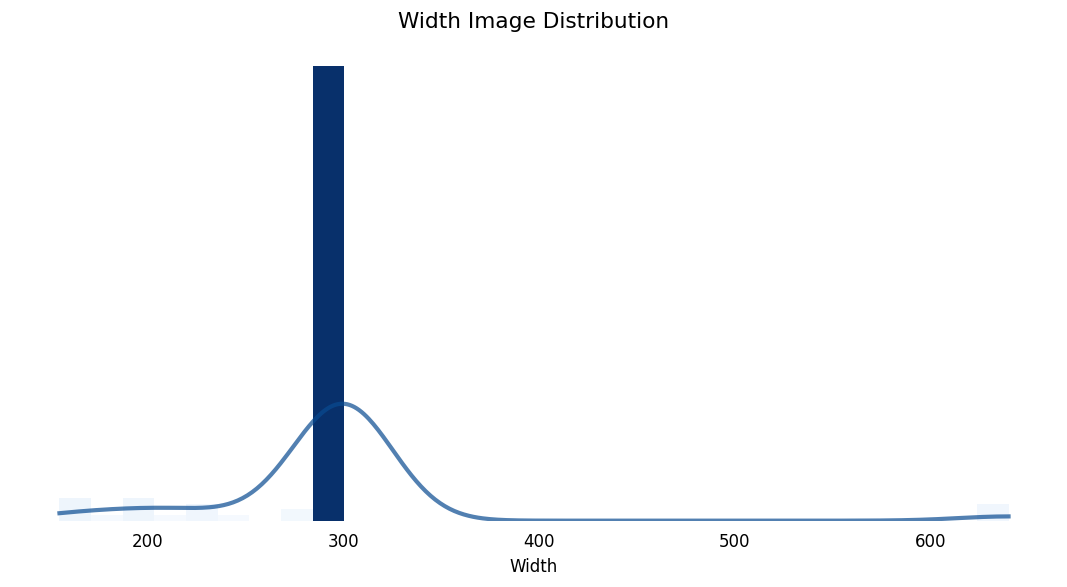

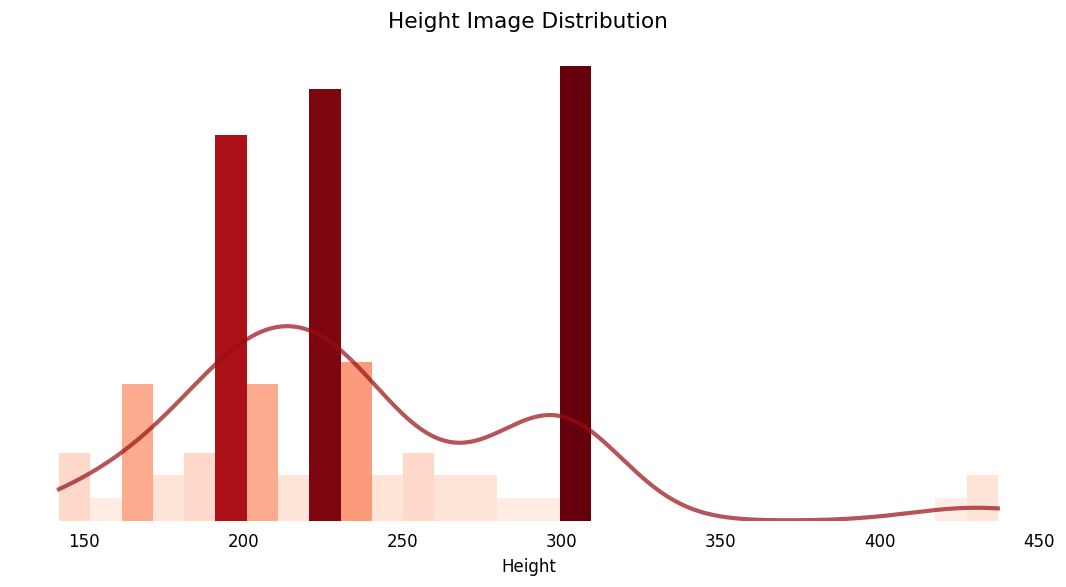

In [7]:
def _silverman_bandwidth(x):
    x = np.asarray(x)
    n  = x.size
    if n < 2:
        return 1.0
    std = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = std if iqr == 0 else min(std, iqr / 1.34)
    h = 0.9 * sigma * n ** (-1/5) if sigma > 0 else 1.0
    return h

def _gaussian_kde(grid, samples, h):
    samples = samples[:, None]
    grid    = grid[None, :]
    u = (grid - samples) / h
    dens = np.exp(-0.5 * u**2).sum(axis=0) / (samples.shape[0] * h * np.sqrt(2*np.pi))
    return dens

def pretty_hist_with_kde(series, title, cmap_name="Blues", bins=30):
    data = series.dropna().to_numpy()
    if data.size == 0:
        print(f"[{title}] no data to plot.")
        return

    fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

    counts, bin_edges, patches = ax.hist(
        data, bins=bins, edgecolor="none"
    )
    bin_width = bin_edges[1] - bin_edges[0]

    cmap = cm.get_cmap(cmap_name)
    norm = Normalize(vmin=0, vmax=max(counts.max(), 1))
    for c, p in zip(counts, patches):
        p.set_facecolor(cmap(norm(c)))

    grid = np.linspace(data.min(), data.max(), 400)
    h = _silverman_bandwidth(data)
    dens = _gaussian_kde(grid, data, h)
    y_kde = dens * data.size * bin_width

    ax.plot(
        grid, y_kde,
        linewidth=2.5,
        alpha=0.7,
        color=cmap(0.9)
    )

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticks([])
    ax.grid(axis="y", linestyle=":", alpha=0.3)

    ax.set_title(title, pad=10, fontsize=13)
    ax.set_xlabel(series.name or "")
    plt.tight_layout()
    plt.show()


dataset_path = f"{BASE_PATH}/raw-img"

image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, f))

print(f"Total Image Detected: {len(image_paths)}")

image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
    except Exception:
        continue

df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print(df_sizes.describe())

pretty_hist_with_kde(df_sizes['Width'],  "Width Image Distribution",  cmap_name="Blues", bins=30)
pretty_hist_with_kde(df_sizes['Height'], "Height Image Distribution", cmap_name="Reds",  bins=30)

### Megapixel Distribution


Top 10 Unique Resolutions (WxH) by Frequency:
   Width  Height  count
0    300     200     14
1    300     225     13
2    300     169      5
3    300     300      5
4    300     232      3
5    169     300      2
6    225     300      2
7    200     300      2
8    300     201      2
9    300     242      2

Megapixel Summary:
count    100.000000
mean       0.071077
std        0.037789
min        0.042600
25%        0.060000
50%        0.066000
75%        0.069675
max        0.279680
Name: MP, dtype: float64


/tmp/ipython-input-3193019902.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


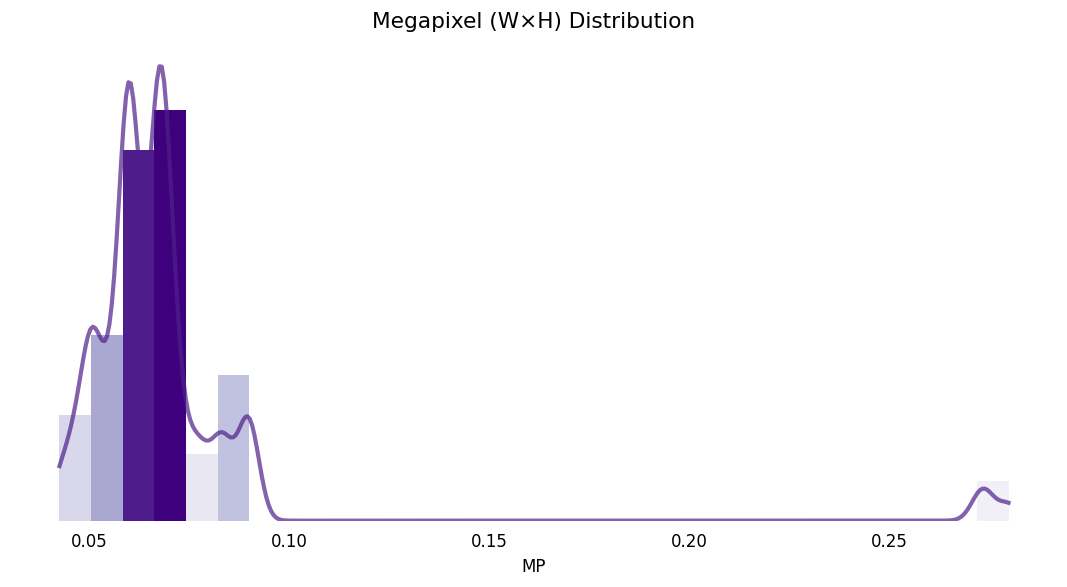

In [8]:
df_sizes["Pixels"] = df_sizes["Width"] * df_sizes["Height"]
df_sizes["MP"]     = df_sizes["Pixels"] / 1_000_000.0

print("\nTop 10 Unique Resolutions (WxH) by Frequency:")
print(df_sizes.value_counts(["Width", "Height"]).rename("count").reset_index().head(10))

print("\nMegapixel Summary:")
print(df_sizes["MP"].describe())

pretty_hist_with_kde(df_sizes["MP"], "Megapixel (W×H) Distribution", cmap_name="Purples", bins=30)


## Data Preparation

### Data Splitting (70:15:15)

In [9]:
random.seed(42)

source_root = f"{BASE_PATH}/raw-img"
base_dir = f"{BASE_PATH}/split-img"
os.makedirs(base_dir, exist_ok=True)

all_10_labels = [
    "dog", "cat", "horse", "butterfly", "chicken",
    "cow", "sheep", "elephant", "spider", "squirrel"
]

english_to_paths = {lbl: [] for lbl in all_10_labels}

for it_folder in os.listdir(source_root):
    if it_folder.startswith("."):
        continue
    class_dir = os.path.join(source_root, it_folder)
    if not os.path.isdir(class_dir):
        continue

    english = translate.get(it_folder, None)
    if english is None:
        continue

    for fname in os.listdir(class_dir):
        if fname.startswith("."):
            continue
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            english_to_paths[english].append(os.path.join(class_dir, fname))

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios Must Sum to 1.0"

for split in ["train", "val", "test"]:
    for cls in all_10_labels:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

def safe_copy(src, dst):
    try:
        shutil.copyfile(src, dst)
    except Exception as e:
        print(f"Copy Failed for {src} -> {dst}: {e}")

summary = {cls: {"train":0, "val":0, "test":0, "total":0} for cls in all_10_labels}

for cls in all_10_labels:
    images = english_to_paths.get(cls, [])
    if not images:
        print(f"Warning - No Images Found for '{cls}'.")
        continue

    valid_images = []
    for p in images:
        try:
            with Image.open(p) as im:
                im.verify()
            valid_images.append(p)
        except (UnidentifiedImageError, OSError):
            continue

    if len(valid_images) == 0:
        print(f"Warning - No Valid Images for '{cls}', Skipping")
        continue

    random.shuffle(valid_images)

    train_and_val, test = train_test_split(valid_images, test_size=test_ratio, random_state=42)
    val_rel = val_ratio / (train_ratio + val_ratio)
    train, val = train_test_split(train_and_val, test_size=val_rel, random_state=42)

    for split_name, subset in [("train", train), ("val", val), ("test", test)]:
        dst_dir = os.path.join(base_dir, split_name, cls)
        for src in subset:
            dst = os.path.join(dst_dir, os.path.basename(src))
            safe_copy(src, dst)
        summary[cls][split_name] = len(subset)
    summary[cls]["total"] = len(valid_images)

print("\nSplit Summary\n")
tot_train = tot_val = tot_test = 0
for cls in all_10_labels:
    tr = summary[cls]["train"]; va = summary[cls]["val"]; te = summary[cls]["test"]; tt = summary[cls]["total"]
    tot_train += tr; tot_val += va; tot_test += te
    print(f"{cls:10s} | Train: {tr:4d} | Val: {va:4d} | Test: {te:4d} | Total: {tt:4d}")

print(f"\nTotals     | Train: {tot_train} | Val: {tot_val} | Test: {tot_test} | Overall: {tot_train+tot_val+tot_test}")
print(f"\nOutput: {base_dir}")



Split Summary

dog        | Train: 3403 | Val:  730 | Test:  730 | Total: 4863
cat        | Train: 1166 | Val:  251 | Test:  251 | Total: 1668
horse      | Train: 1835 | Val:  394 | Test:  394 | Total: 2623
butterfly  | Train: 1478 | Val:  317 | Test:  317 | Total: 2112
chicken    | Train: 2168 | Val:  465 | Test:  465 | Total: 3098
cow        | Train: 1306 | Val:  280 | Test:  280 | Total: 1866
sheep      | Train: 1274 | Val:  273 | Test:  273 | Total: 1820
elephant   | Train: 1012 | Val:  217 | Test:  217 | Total: 1446
spider     | Train: 3374 | Val:  723 | Test:  724 | Total: 4821
squirrel   | Train: 1302 | Val:  280 | Test:  280 | Total: 1862

Totals     | Train: 18318 | Val: 3930 | Test: 3931 | Overall: 26179

Output: /content//split-img


### Data Generator

In [10]:
SEED        = 1337
IMAGE_SIZE  = (224, 224)
BATCH_SIZE  = 32

ds_dir  = f"{BASE_PATH}raw-img"
out_dir = f"{BASE_PATH}split-img"

train_dir = os.path.join(out_dir, "train")
val_dir   = os.path.join(out_dir, "val")
test_dir  = os.path.join(out_dir, "test")

USE_MOBILENET_PREPROCESS = False

if USE_MOBILENET_PREPROCESS:
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=10,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    eval_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

validation_generator = eval_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_generator = eval_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)


print("\nClasses:", train_generator.class_indices)
print(f"Train: {train_generator.samples} | Val: {validation_generator.samples} | Test: {test_generator.samples}")

Found 18318 images belonging to 10 classes.
Found 3930 images belonging to 10 classes.
Found 3931 images belonging to 10 classes.

Classes: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
Train: 18318 | Val: 3930 | Test: 3931


## Modelling

### Hybrid CNN Model: MobileNetV2 + Sequential

In [11]:
input_shape = train_generator.image_shape
num_classes = len(train_generator.class_indices)

base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
for layer in base.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,104,778 (11.84 MB)

 Trainable params: 846,794 (3.23 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction   = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5, verbose=1)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_reduction]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 264s 415ms/step - accuracy: 0.7551 - loss: 0.7969 - val_accuracy: 0.9326 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 208s 364ms/step - accuracy: 0.9274 - loss: 0.2763 - val_accuracy: 0.9377 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 210s 366ms/step - accuracy: 0.9423 - loss: 0.2146 - val_accuracy: 0.9415 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 210s 367ms/step - accuracy: 0.9480 - loss: 0.1954 - val_accuracy: 0.9453 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 211s 369ms/step - accuracy: 0.9505 - loss: 0.1859 - val_accuracy: 0.9415 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 209s 365ms/step - accuracy: 0.9543 - loss: 0.1727 - val_accuracy: 0.9364 - val_loss: 0.2225 - learning_rate: 0.0010
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy

### Test Accuracy

In [13]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9479 | Test Loss: 0.2117


### Fine Tune

In [14]:
N = 20
for layer in base.layers[-N:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 250s 408ms/step - accuracy: 0.9237 - loss: 0.2795 - val_accuracy: 0.9499 - val_loss: 0.1882
Epoch 2/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 221s 386ms/step - accuracy: 0.9486 - loss: 0.1826 - val_accuracy: 0.9494 - val_loss: 0.1939
Epoch 3/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 213s 372ms/step - accuracy: 0.9589 - loss: 0.1569 - val_accuracy: 0.9478 - val_loss: 0.1918
Epoch 4/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 263s 375ms/step - accuracy: 0.9590 - loss: 0.1364 - val_accuracy: 0.9501 - val_loss: 0.1901
Epoch 5/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 216s 377ms/step - accuracy: 0.9640 - loss: 0.1213 - val_accuracy: 0.9483 - val_loss: 0.1874


### Test Accuracy After Fine Tune

In [15]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9456 | Test Loss: 0.2123


## Model Plot

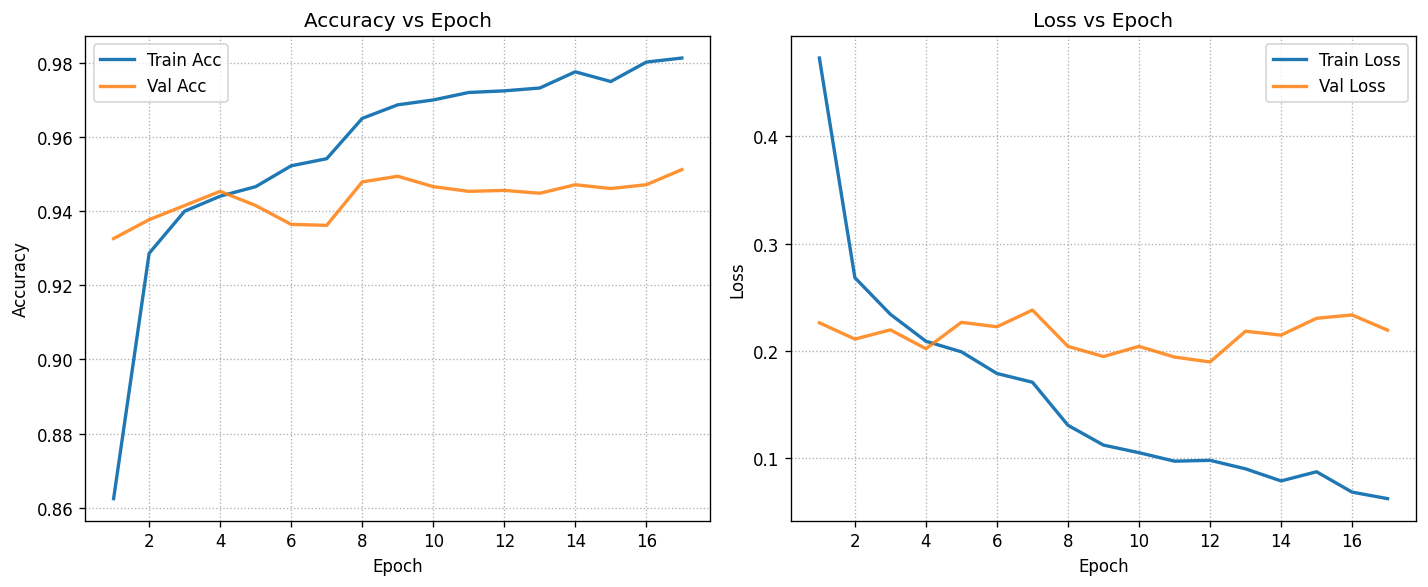

In [16]:
hist = history.history
acc_key_candidates = ["accuracy", "sparse_categorical_accuracy", "acc"]
acc_key = next(k for k in acc_key_candidates if k in hist)

val_acc_key_candidates = [f"val_{acc_key}", "val_accuracy", "val_sparse_categorical_accuracy", "val_acc"]
val_acc_key = next(k for k in val_acc_key_candidates if k in hist)

epochs = range(1, len(hist[acc_key]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

ax1.plot(epochs, hist[acc_key], label="Train Acc", linewidth=2)
ax1.plot(epochs, hist[val_acc_key], label="Val Acc", linewidth=2, alpha=0.85)
ax1.set_title("Accuracy vs Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.grid(True, linestyle=":")
ax1.legend()

ax2.plot(epochs, hist["loss"], label="Train Loss", linewidth=2)
ax2.plot(epochs, hist["val_loss"], label="Val Loss", linewidth=2, alpha=0.85)
ax2.set_title("Loss vs Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True, linestyle=":")
ax2.legend()

plt.tight_layout()
plt.show()

## Export & Convert Models (TFJS, TFLITE, SavedModels)

In [17]:
def export_model_to_gdrive_k3(model, drive_subdir="ModelExports", save_name="mobilenetv2_cnn", save_class_indices_from=None):
    try:
        if not os.path.ismount(f"{BASE_PATH}drive"):
            drive.mount(f"{BASE_PATH}drive", force_remount=False)
        gdrive_root = f"{BASE_PATH}drive/MyDrive"
    except Exception:
        print("[WARN] Not in Colab - Using Current Working Directory Instead")
        gdrive_root = os.getcwd()

    out_dir     = os.path.join(gdrive_root, drive_subdir)
    saved_dir   = os.path.join(out_dir, f"{save_name}_savedmodel")
    tfjs_dir    = os.path.join(out_dir, f"{save_name}_tfjs")
    tflite_path = os.path.join(out_dir, f"{save_name}.tflite")

    os.makedirs(out_dir, exist_ok=True)

    for p in [saved_dir, tfjs_dir]:
        if os.path.exists(p):
            shutil.rmtree(p)

    print(">> Exporting SavedModel ...")
    model.export(saved_dir)

    print(">> Exporting TFJS Layers Format ...")
    tfjs.converters.save_keras_model(model, tfjs_dir)

    print(">> Converting TFLite (FP32) ...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_bytes = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_bytes)

    if save_class_indices_from is not None and hasattr(save_class_indices_from, "class_indices"):
        with open(os.path.join(out_dir, f"{save_name}_class_indices.json"), "w") as f:
            json.dump(save_class_indices_from.class_indices, f, indent=2)

    print("\nExport Complete")
    print("Drive folder:", out_dir)
    print("> SavedModel :", saved_dir)
    print("> TFJS       :", tfjs_dir)
    print("> TFLite     :", tflite_path)
    print("Open in Drive: /MyDrive/" + drive_subdir)

In [18]:
export_model_to_gdrive_k3(
    model,
    drive_subdir="Belajar Fundamental Deep Learning",
    save_name="mobilenetv2_cnn",
    save_class_indices_from=train_generator
)

Mounted at /content/drive
>> Exporting SavedModel ...
Saved artifact at '/content/drive/MyDrive/Belajar Fundamental Deep Learning/mobilenetv2_cnn_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133875742917072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742919952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742917456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742920720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742919184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742921296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742920912: TensorSpec(

>> Exporting TFJS Layers Format ...
failed to lookup keras version from the file,
    this is likely a weight only file
>> Converting TFLite (FP32) ...
Saved artifact at '/tmp/tmpfuimxxz9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133875742917072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742919952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742917456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742920720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742919184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133875742921296: TensorSpec(shape=(), dtype=tf.resource, name=None)

## Freeze PIP

In [19]:
def save_pip_freeze_to_gdrive(drive_subdir="Belajar Fundamental Deep Learning", filename="requirements.txt"):
    try:
        if not os.path.ismount(f"{BASE_PATH}drive"):
            drive.mount(f"{BASE_PATH}drive", force_remount=False)
        gdrive_root = f"{BASE_PATH}drive/MyDrive"
    except Exception:
        print("[WARN] Not in Colab - Using Current Working Directory")
        gdrive_root = os.getcwd()

    out_dir = os.path.join(gdrive_root, drive_subdir)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, filename)

    with open(out_path, "w") as f:
        subprocess.run([sys.executable, "-m", "pip", "freeze"], stdout=f, check=True)

    print("Wrote:", out_path)

save_pip_freeze_to_gdrive(drive_subdir="Belajar Fundamental Deep Learning", filename="requirements.txt")

Wrote: /content/drive/MyDrive/Belajar Fundamental Deep Learning/requirements.txt


## Inference Model

Using Image: /content/split-img/test/butterfly/OIP--VatM86VAW7kByE6tVfTfgHaHV.jpeg


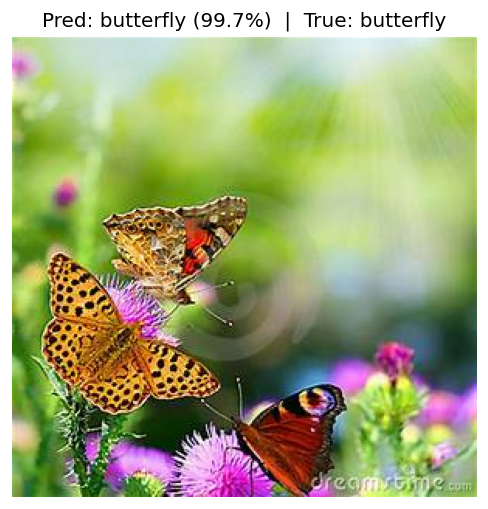


Top-5:
      butterfly: 0.9974
         spider: 0.0026
       squirrel: 0.0000
        chicken: 0.0000
            cat: 0.0000


In [20]:
try:
    if not os.path.ismount(f"{BASE_PATH}drive"):
        drive.mount(f"{BASE_PATH}drive", force_remount=False)
    GDRIVE_ROOT = f"{BASE_PATH}drive/MyDrive"
except Exception:
    print("[WARN] Not in Colab - using current working directory.")
    GDRIVE_ROOT = os.getcwd()

SAVED_MODEL_DIR  = f"{GDRIVE_ROOT}/Belajar Fundamental Deep Learning/mobilenetv2_cnn_savedmodel"
CLASS_INDEX_PATH = f"{GDRIVE_ROOT}/Belajar Fundamental Deep Learning/mobilenetv2_cnn_class_indices.json"

# Option A: Pick a Specific Image on Drive
# IMG_PATH = f"{GDRIVE_ROOT}/some_folder/example.jpg"

# Option B: Auto-Pick Test Set:
TEST_ROOT = f"{BASE_PATH}split-img/test"
CANDIDATES = sorted(glob.glob(os.path.join(TEST_ROOT, "**", "*.*"), recursive=True))
if not CANDIDATES:
    raise FileNotFoundError("No Test Image Found. Set IMG_PATH to Valid Path On Drive.")
IMG_PATH = CANDIDATES[0]
print("Using Image:", IMG_PATH)

IMAGE_SIZE = (224, 224)
USE_MOBILENET_PREPROCESS = True

def load_image_for_model(path, image_size=(224,224), mobilenet_preprocess=True):

    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img_disp = img.numpy()

    img = tf.image.resize(img, image_size, antialias=True)
    x = tf.image.convert_image_dtype(img, tf.float32)
    x = tf.expand_dims(x, 0)

    if mobilenet_preprocess:

        x = preprocess_input(x * 255.0)

    return x, img_disp

loaded = tf.saved_model.load(SAVED_MODEL_DIR)
infer = loaded.signatures["serving_default"]

x, img_disp = load_image_for_model(IMG_PATH, IMAGE_SIZE, USE_MOBILENET_PREPROCESS)

try:
    outputs = infer(x)
except TypeError:
    in_name = list(infer.structured_input_signature[1].keys())[0]
    outputs = infer(**{in_name: x})

y = list(outputs.values())[0].numpy()
probs = y[0]
pred_idx = int(np.argmax(probs))
conf = float(probs[pred_idx])

pred_label = str(pred_idx)
if os.path.exists(CLASS_INDEX_PATH):
    with open(CLASS_INDEX_PATH, "r") as f:
        class_indices = json.load(f)
    idx_to_name = {v: k for k, v in class_indices.items()}
    pred_label = idx_to_name.get(pred_idx, pred_label)

true_label = Path(IMG_PATH).parent.name

plt.figure(figsize=(5,5), dpi=120)
plt.imshow(img_disp)
plt.axis("off")
title = f"Pred: {pred_label} ({conf*100:.1f}%)"
if true_label:
    title += f"  |  True: {true_label}"
plt.title(title)
plt.show()

top5_idx = probs.argsort()[-5:][::-1]
print("\nTop-5:")
for i in top5_idx:
    name = idx_to_name.get(int(i), str(int(i))) if 'idx_to_name' in locals() else str(int(i))
    print(f"{name:>15s}: {probs[i]:.4f}")